# Clean Text Data

In [117]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [118]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [119]:
#if IN_COLAB:
  # Uninstall existing versions:
  #!pip uninstall numpy -y
  #!pip uninstall pandas -y
  #!pip uninstall tqdm -y
  #!pip uninstall torch -y
  #!pip uninstall scikit-plot -y
  #!pip uninstall transformers -y
  
  # Install packages:
  #!pip install numpy==1.16.4
  #!pip install pandas
  #!pip install torch==1.4.0
  #!pip install tqdm==4.43.0
  #!pip install scikit-plot
  #!pip install transformers

In [120]:
import pprint
pprint.pprint(sys.path)

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


In [121]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [122]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

## Define Utility Functions

In [123]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar['date'].iloc[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar['date'].iloc[i]:
                return fomc_calendar['date'].iloc[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [124]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [125]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [126]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [127]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [128]:
file = open(fomc_dir + 'fomc_calendar.pickle', 'rb')
fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(454, 4)


,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
449,2021-06-16,False,True,False
450,2021-07-28,False,False,False
451,2021-09-22,False,True,False
452,2021-11-03,False,False,False


In [129]:
# #Check caleander
# fomc_calendar.loc[fomc_calendar.index >= dt.datetime(1998, 1, 27)]

### Statement

In [130]:
file = open(fomc_dir + 'statement.pickle', 'rb')
statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(201, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,FOMC Statement
...,...,...,...,...
196,2020-06-10,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement
197,2020-07-29,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement
198,2020-08-27,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement
199,2020-09-16,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Statement


In [131]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [132]:
file = open(fomc_dir + 'minutes.pickle', 'rb')
minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(229, 4)


,date,contents,speaker,title
0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
...,...,...,...,...
224,2020-03-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes
225,2020-04-29,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes
226,2020-06-10,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes
227,2020-07-29,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes


In [133]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [134]:
file = open(fomc_dir + 'meeting_script.pickle', 'rb')
meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting ...,other,FOMC Meeting Transcript
2,1980-03-18,CHAIRMAN VOLCKER. The meeting can come to orde...,other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER.\rCan we come to order, ladie...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and g...",other,FOMC Meeting Transcript
...,...,...,...,...
277,2014-06-18,CHAIR YELLEN. I’d like to begin by welcoming t...,Janet Yellen,FOMC Meeting Transcript
278,2014-07-30,"CHAIR YELLEN. Good morning, everybody. I would...",Janet Yellen,FOMC Meeting Transcript
279,2014-09-17,"CHAIR YELLEN. Good morning, everybody.\rOur fi...",Janet Yellen,FOMC Meeting Transcript
280,2014-10-29,CHAIR YELLEN. I’d like to call this meeting to...,Janet Yellen,FOMC Meeting Transcript


In [135]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

the Board meeting.

[SECTION]

MR. FISCHER. So moved.

[SECTION]

Simon to give us his report on market developments.

[SECTION]

to answer questions before moving on to Lorie’s part.

[SECTION]

CHAIR YELLEN. Questions for Simon? President Fisher.

[SECTION]

want to clarify that. So it’s mainly energy-driven.

[SECTION]

right.

[SECTION]

because you referenced them just now.

[SECTION]



[SECTION]

in mortgage-backed securities. Is that correct?

[SECTION]

MR. POTTER. It’s $2.5 trillion in Treasuries, I thought.

[SECTION]

Treasury redemptions in 2015, so nothing to speak of—

[SECTION]

MR. POTTER. That’s correct.

[SECTION]

for 2015 will be approximately $20 billion per month.

[SECTION]

MR. POTTER. Maybe a little bit higher, but about that level.

[SECTION]

net issuance.

[SECTION]

MR. POTTER. Correct.

[SECTION]

So it’s really taking five years, and, therefore, we would reduce by $900 billion over that fiveyear period. Correct?

[SECTION]

MR. POTTER. Yes. That’s the po

### Press Conference Transcripts

In [136]:
file = open(fomc_dir + 'press_conference.pickle', 'rb')
presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(47, 4)


,date,contents,speaker,title
0,2011-04-27,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...,Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,CHAIRMAN BERNANKE. Good afternoon and welcome....,Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. ...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome....,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,CHAIRMAN BERNANKE. Good afternoon. Before we g...,Ben Bernanke,FOMC Press Conference Transcript
...,...,...,...,...
42,2020-04-29,CHAIR POWELL. Good afternoon. Thanks for joini...,Jerome Powell,FOMC Press Conference Transcript
43,2020-06-10,"CHAIR POWELL. Good afternoon, everyone, and th...",Jerome Powell,FOMC Press Conference Transcript
44,2020-07-29,CHAIR POWELL. Good afternoon. The pandemic con...,Jerome Powell,FOMC Press Conference Transcript
45,2020-09-16,CHAIR POWELL. Good afternoon. At the Federal R...,Jerome Powell,FOMC Press Conference Transcript


In [137]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

Transcript of Chair Powell’s Press Conference

[SECTION]



[SECTION]



[SECTION]



[SECTION]



[SECTION]

Thank you, I look forward to your questions.

[SECTION]

we've seen going into flu season. Thank you.

[SECTION]



[SECTION]

expansion but at a gradually moderating pace.

[SECTION]

the economy if it does not get passed, say, before January.

[SECTION]



[SECTION]

should be and leave it at that.

[SECTION]

MICHELLE SMITH, Nick Timiraos.

[SECTION]

diminished here, given the low level of short- and long-term rates. Thank you.

[SECTION]



[SECTION]

generally that there will be something.

[SECTION]

MICHELLE SMITH. Thank you. Steve Liesman, CNBC.

[SECTION]

be rising even above 1 percent? Thank you.

[SECTION]



[SECTION]

the markets, and so it continues.

[SECTION]

MICHELLE SMITH. Thank you. Craig Torres, Bloomberg.

[SECTION]



[SECTION]

boundary or that the economy does when we exit this. Thanks.

[SECTION]



[SECTION]

[ Silence ]

[SECTION]

consequences if 

### Speech

In [138]:
file = open(fomc_dir + 'speech.pickle', 'rb')
speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1490, 4)


,date,contents,speaker,title
0,1996-06-13,Remarks by Chairman Alan Greenspan\nBank super...,Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDev...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SE...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,Remarks by Chairman Alan Greenspan\nRegulation...,Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,Remarks by Governor Lawrence B. Lindsey\r\nAt ...,Governor Lawrence B. Lindsey,Small business is big business
...,...,...,...,...
1485,2020-10-20,"The Federal Reserve, the central bank of the U...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations:...
1486,2020-10-21,"The Federal Reserve, the central bank of the U...",Governor Lael Brainard,Achieving a Broad-Based and Inclusive Recovery
1487,2020-11-10,"The Federal Reserve, the central bank of the U...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations:...
1488,2020-11-16,"The Federal Reserve, the central bank of the U...",Vice Chair Richard H. Clarida,The Federal Reserve's New Framework: Context a...


In [139]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [140]:
file = open(fomc_dir + 'testimony.pickle', 'rb')
testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(442, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION...,"Herbert A. Biern, Deputy Associate Director, D...","""Prime bank"" schemes"
2,1996-07-18,Testimony of Chairman Alan Greenspan\nThe Fede...,Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
...,...,...,...,...
437,2020-06-30,"The Federal Reserve, the central bank of the U...",Chair Jerome H. Powell,Coronavirus and CARES Act
438,2020-09-08,"The Federal Reserve, the central bank of the U...","Testimony by Sheila Clark, Program Director, O...",Diversity and Inclusion
439,2020-09-17,"The Federal Reserve, the central bank of the U...","Kent Hiteshew, Deputy Associate Director, Divi...",Municipal Liquidity Facility
440,2020-09-22,"The Federal Reserve, the central bank of the U...",Chair Jerome H. Powell,"Coronavirus Aid, Relief, and Economic Security..."


In [141]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [142]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan annou...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today ann...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [143]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [144]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  202
Shape of the dataframe:  (202, 13)


In [145]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,<NA>,None,1994-07-06,<NA>,None,[SECTION]The Federal Reserve today announced t...,"[, The Federal Reserve today announced two act...",\n\n[SECTION]\n\nThe Federal Reserve today ann...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,<NA>,None,1994-09-27,<NA>,None,[SECTION]The Federal Reserve announced today t...,"[, The Federal Reserve announced today the fol...",\n\n[SECTION]\n\nThe Federal Reserve announced...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,604,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
198,statement,2020-08-27,FOMC Statement,Jerome Powell,603,<NA>,None,2020-09-16,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
199,statement,2020-09-16,FOMC Statement,Jerome Powell,700,<NA>,None,2020-11-05,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
200,statement,2020-11-05,FOMC Statement,Jerome Powell,618,<NA>,None,2020-12-16,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


In [146]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,[SECTION]Chairman Alan Greenspan announced tod...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,<NA>,None,1994-07-06,<NA>,None,[SECTION]The Federal Reserve today announced t...,"[, The Federal Reserve today announced two act...",\n\n[SECTION]\n\nThe Federal Reserve today ann...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,<NA>,None,1994-09-27,<NA>,None,[SECTION]The Federal Reserve announced today t...,"[, The Federal Reserve announced today the fol...",\n\n[SECTION]\n\nThe Federal Reserve announced...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,604,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
198,statement,2020-08-27,FOMC Statement,Jerome Powell,603,<NA>,None,2020-09-16,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
199,statement,2020-09-16,FOMC Statement,Jerome Powell,700,<NA>,None,2020-11-05,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
200,statement,2020-11-05,FOMC Statement,Jerome Powell,618,<NA>,None,2020-12-16,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


In [ ]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar['date'].iloc[fomc_calendar.index > x]

In [148]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,Chairman Alan Greenspan announced today that t...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,Chairman Alan Greenspan announced today that t...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,Chairman Alan Greenspan announced today that t...,"[, Chairman Alan Greenspan announced today tha...",\n\n[SECTION]\n\nChairman Alan Greenspan annou...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,<NA>,None,1994-07-06,<NA>,None,"In taking the discount action, the Board appro...","[, The Federal Reserve today announced two act...",\n\n[SECTION]\n\nThe Federal Reserve today ann...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,<NA>,None,1994-09-27,<NA>,None,"In taking the discount rate action, the Board ...","[, The Federal Reserve announced today the fol...",\n\n[SECTION]\n\nThe Federal Reserve announced...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,378,<NA>,None,2020-08-27,<NA>,None,The coronavirus outbreak is causing tremendous...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
198,statement,2020-08-27,FOMC Statement,Jerome Powell,387,<NA>,None,2020-09-16,<NA>,None,Following an extensive review that included nu...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
199,statement,2020-09-16,FOMC Statement,Jerome Powell,434,<NA>,None,2020-11-05,<NA>,None,The COVID-19 pandemic is causing tremendous hu...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
200,statement,2020-11-05,FOMC Statement,Jerome Powell,336,<NA>,None,2020-12-16,<NA>,None,The COVID-19 pandemic is causing tremendous hu...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


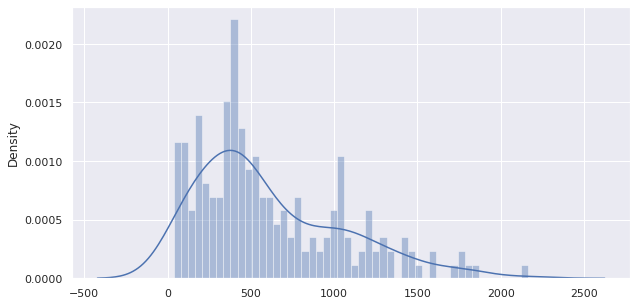

In [149]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [150]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
854,statement,2020-07-29,FOMC Statement,Jerome Powell,78,<NA>,None,2020-08-27,<NA>,None,and businesses over coming months the Federal ...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
855,statement,2020-08-27,FOMC Statement,Jerome Powell,200,<NA>,None,2020-09-16,<NA>,None,Following an extensive review that included nu...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
856,statement,2020-08-27,FOMC Statement,Jerome Powell,200,<NA>,None,2020-09-16,<NA>,None,market can be sustained without causing an unw...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
857,statement,2020-08-27,FOMC Statement,Jerome Powell,87,<NA>,None,2020-09-16,<NA>,None,communications htm Finally the Committee explo...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
858,statement,2020-09-16,FOMC Statement,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,The COVID pandemic is causing tremendous human...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
859,statement,2020-09-16,FOMC Statement,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,these outcomes are achieved The Committee deci...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
860,statement,2020-09-16,FOMC Statement,Jerome Powell,134,<NA>,None,2020-11-05,<NA>,None,that could impede the attainment of the Commit...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
861,statement,2020-11-05,FOMC Statement,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,The COVID pandemic is causing tremendous human...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
862,statement,2020-11-05,FOMC Statement,Jerome Powell,186,<NA>,None,2020-12-16,<NA>,None,achieved The Committee decided to keep the tar...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
863,statement,2008-11-25,FOMC statement,Ben Bernanke,192,<NA>,None,2008-12-16,<NA>,None,The Federal Reserve announced on Tuesday that ...,[The Federal Reserve announced on Tuesday that...,The Federal Reserve announced on Tuesday that ...


### Filter out by keywords

In [151]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(108, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,<NA>,None,1994-07-06,<NA>,None,The Board approved an increase in the discount...,[The Board approved an increase in the discoun...,\n\n[SECTION]\n\nThe Federal Reserve today ann...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,<NA>,None,1994-12-20,<NA>,None,"In a related move, the Federal Open Market Com...","[In a related move, the Federal Open Market Co...",\n\n[SECTION]\n\nThe Federal Reserve Board tod...
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,<NA>,None,1996-03-26,<NA>,None,For immediate releaseThe Federal Reserve today...,[For immediate releaseThe Federal Reserve toda...,For immediate release\n\n\n\n\n\n\r\n\r\nThe F...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,<NA>,None,1997-05-20,<NA>,None,For immediate release\tThe Federal Open Market...,[For immediate release\tThe Federal Open Marke...,For immediate release\n\n\n\n\n\n\r\n\r\n\tThe...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,<NA>,None,1998-10-15,<NA>,None,For immediate releaseThe Federal Open Market C...,[For immediate releaseThe Federal Open Market ...,For immediate release\n\n\n\n\n\n\r\nThe Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,statement,2020-04-29,FOMC Statement,Jerome Powell,83,<NA>,None,2020-06-10,<NA>,None,The ongoing public health crisis will weigh he...,[The ongoing public health crisis will weigh h...,"The Federal Reserve, the central bank of the U..."
104,statement,2020-06-10,FOMC Statement,Jerome Powell,83,<NA>,None,2020-07-29,<NA>,None,The ongoing public health crisis will weigh he...,[The ongoing public health crisis will weigh h...,"The Federal Reserve, the central bank of the U..."
105,statement,2020-07-29,FOMC Statement,Jerome Powell,97,<NA>,None,2020-08-27,<NA>,None,The path of the economy will depend significan...,[The path of the economy will depend significa...,"The Federal Reserve, the central bank of the U..."
106,statement,2020-09-16,FOMC Statement,Jerome Powell,95,<NA>,None,2020-11-05,<NA>,None,Voting against the action were Robert S. Kapla...,[The path of the economy will depend significa...,"The Federal Reserve, the central bank of the U..."


In [152]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [153]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes


In [154]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  229
Shape of the dataframe:  (229, 13)


In [155]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
225,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,8872,<NA>,None,2020-06-10,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
226,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,9995,<NA>,None,2020-07-29,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
227,minutes,2020-07-29,FOMC Meeting Minutes,Jerome Powell,8909,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


In [156]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
225,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,8872,<NA>,None,2020-06-10,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
226,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,9995,<NA>,None,2020-07-29,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
227,minutes,2020-07-29,FOMC Meeting Minutes,Jerome Powell,8909,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


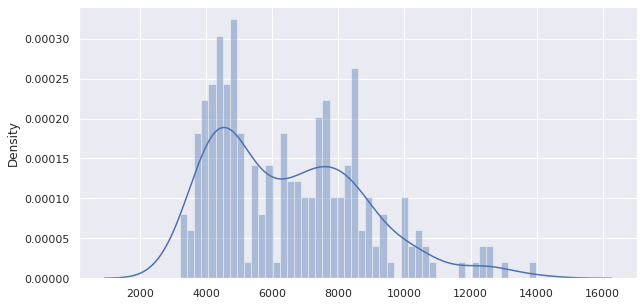

In [157]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [158]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,A meeting of the Federal Open Market Committee...,[A meeting of the Federal Open Market Committe...,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
225,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,8872,<NA>,None,2020-06-10,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
226,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,9995,<NA>,None,2020-07-29,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
227,minutes,2020-07-29,FOMC Meeting Minutes,Jerome Powell,8909,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the U...","[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [159]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [160]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [161]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [162]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8537, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8527,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,at the current pace These actions would contin...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8528,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,in part reflecting policy measures to support ...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8529,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,in the new consensus statement in pursuit of t...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8530,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,all members agreed on a specification for outc...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8531,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,a stronger formulation for the forward one in ...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8532,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,including readings on public health labor mark...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8533,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,the holdings of agency CMBS in the SOMA portfo...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8534,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,employment have picked up in recent months but...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8535,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,expects it will be appropriate to maintain thi...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."
8536,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,168,<NA>,None,2020-11-05,<NA>,None,including readings on public health labor mark...,"[The Federal Reserve, the central bank of the ...","The Federal Reserve, the central bank of the U..."


### Filter out by keywords

In [163]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(229, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,<NA>,None,1993-02-18,<NA>,None,The nominal U.S. merchandise trade deficit wid...,[The nominal U.S. merchandise trade deficit wi...,A meeting of the Federal Open Market Committee...
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,<NA>,None,1993-05-18,<NA>,None,"In foreign exchange markets, the trade-weighte...","[In foreign exchange markets, the trade-weight...",A meeting of the Federal Open Market Committee...
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,<NA>,None,1993-07-07,<NA>,None,"In foreign exchange markets, the trade-weighte...","[In foreign exchange markets, the trade-weight...",A meeting of the Federal Open Market Committee...
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,<NA>,None,1993-08-17,<NA>,None,Other short-term interest rates also were litt...,[Other short-term interest rates also were lit...,A meeting of the Federal Open Market Committee...
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,<NA>,None,1993-09-21,<NA>,None,Money market interest rates were little change...,[Money market interest rates were little chang...,A meeting of the Federal Open Market Committee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,2280,<NA>,None,2020-03-19,<NA>,None,Developments in Financial Markets and Open Mar...,[Developments in Financial Markets and Open Ma...,"The Federal Reserve, the central bank of the U..."
225,minutes,2020-04-29,FOMC Meeting Minutes,Jerome Powell,1651,<NA>,None,2020-06-10,<NA>,None,Conditions in money markets had improved over ...,[Conditions in money markets had improved over...,"The Federal Reserve, the central bank of the U..."
226,minutes,2020-06-10,FOMC Meeting Minutes,Jerome Powell,2598,<NA>,None,2020-07-29,<NA>,None,"Discussion of Forward Guidance, Asset Purchase...","[Discussion of Forward Guidance, Asset Purchas...","The Federal Reserve, the central bank of the U..."
227,minutes,2020-07-29,FOMC Meeting Minutes,Jerome Powell,2770,<NA>,None,2020-08-27,<NA>,None,"Review of Monetary Policy Strategy, Tools, and...","[Review of Monetary Policy Strategy, Tools, an...","The Federal Reserve, the central bank of the U..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


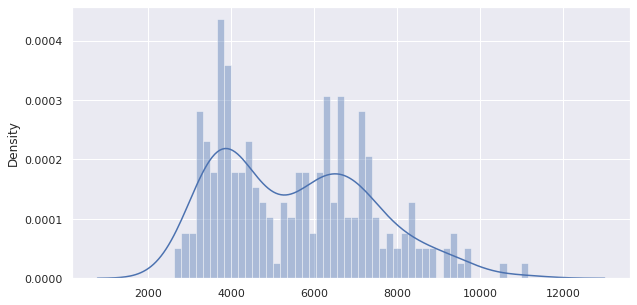

In [164]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [165]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [166]:
# Sample
print(presconf_script_df['contents'][2])

Thank you for your patience, and I would be happy to take your questions.

[SECTION]

policy, in your opinion?

[SECTION]

at least, not proved to be very valid.

[SECTION]

STEVE LIESMAN. Was the letter appropriate?

[SECTION]

going to do.

[SECTION]

And what are your views on the advantages and disadvantages of that approach?

[SECTION]

date—at this time—any radical change in framework. We are going to stay within the dualmandate approach that we’ve been using until this point.

[SECTION]

economy?

[SECTION]

address inequality per se.

[SECTION]

how people should interpret those two messages?

[SECTION]

necessarily move in mid-2013 with those conditions prevailing that you described.

[SECTION]

proposal?

[SECTION]

conditions were appropriate. So the answer is yes, we would certainly look at that.

[SECTION]

know that U.S. companies don’t about investing in the U.S.?

[SECTION]

but it’s still obviously too low to be consistent with a full employment economy.

[SECTION]

th

In [167]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  47
Shape of the dataframe:  (47, 13)


In [168]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8761,<NA>,None,2011-06-22,<NA>,None,CHAIRMAN BERNANKE. Good afternoon. Welcome.In ...,[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7363,<NA>,None,2011-08-01,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome....,[CHAIRMAN BERNANKE. Good afternoon and welcome...,CHAIRMAN BERNANKE. Good afternoon and welcome....
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7358,<NA>,None,2011-11-28,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon, everybody. ...","[CHAIRMAN BERNANKE. Good afternoon, everybody....","CHAIRMAN BERNANKE. Good afternoon, everybody. ..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10134,<NA>,None,2012-03-13,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome....,[CHAIRMAN BERNANKE. Good afternoon and welcome...,CHAIRMAN BERNANKE. Good afternoon and welcome....
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7678,<NA>,None,2012-06-20,<NA>,None,CHAIRMAN BERNANKE. Good afternoon. Before we g...,[CHAIRMAN BERNANKE. Good afternoon. Before we ...,CHAIRMAN BERNANKE. Good afternoon. Before we g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,8211,<NA>,None,2020-06-10,<NA>,None,CHAIR POWELL. Good afternoon. Thanks for joini...,[CHAIR POWELL. Good afternoon. Thanks for join...,CHAIR POWELL. Good afternoon. Thanks for joini...
43,presconf_script,2020-06-10,FOMC Press Conference Transcript,Jerome Powell,10538,<NA>,None,2020-07-29,<NA>,None,"CHAIR POWELL. Good afternoon, everyone, and th...","[CHAIR POWELL. Good afternoon, everyone, and t...","CHAIR POWELL. Good afternoon, everyone, and th..."
44,presconf_script,2020-07-29,FOMC Press Conference Transcript,Jerome Powell,10127,<NA>,None,2020-08-27,<NA>,None,CHAIR POWELL. Good afternoon. The pandemic con...,[CHAIR POWELL. Good afternoon. The pandemic co...,CHAIR POWELL. Good afternoon. The pandemic con...
45,presconf_script,2020-09-16,FOMC Press Conference Transcript,Jerome Powell,11042,<NA>,None,2020-11-05,<NA>,None,CHAIR POWELL. Good afternoon. At the Federal R...,[CHAIR POWELL. Good afternoon. At the Federal ...,CHAIR POWELL. Good afternoon. At the Federal R...


In [169]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8761,<NA>,None,2011-06-22,<NA>,None,CHAIRMAN BERNANKE. Good afternoon. Welcome.In ...,[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7363,<NA>,None,2011-08-01,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome....,[CHAIRMAN BERNANKE. Good afternoon and welcome...,CHAIRMAN BERNANKE. Good afternoon and welcome....
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7358,<NA>,None,2011-11-28,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon, everybody. ...","[CHAIRMAN BERNANKE. Good afternoon, everybody....","CHAIRMAN BERNANKE. Good afternoon, everybody. ..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10134,<NA>,None,2012-03-13,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome....,[CHAIRMAN BERNANKE. Good afternoon and welcome...,CHAIRMAN BERNANKE. Good afternoon and welcome....
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7678,<NA>,None,2012-06-20,<NA>,None,CHAIRMAN BERNANKE. Good afternoon. Before we g...,[CHAIRMAN BERNANKE. Good afternoon. Before we ...,CHAIRMAN BERNANKE. Good afternoon. Before we g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,8211,<NA>,None,2020-06-10,<NA>,None,CHAIR POWELL. Good afternoon. Thanks for joini...,[CHAIR POWELL. Good afternoon. Thanks for join...,CHAIR POWELL. Good afternoon. Thanks for joini...
43,presconf_script,2020-06-10,FOMC Press Conference Transcript,Jerome Powell,10538,<NA>,None,2020-07-29,<NA>,None,"CHAIR POWELL. Good afternoon, everyone, and th...","[CHAIR POWELL. Good afternoon, everyone, and t...","CHAIR POWELL. Good afternoon, everyone, and th..."
44,presconf_script,2020-07-29,FOMC Press Conference Transcript,Jerome Powell,10127,<NA>,None,2020-08-27,<NA>,None,CHAIR POWELL. Good afternoon. The pandemic con...,[CHAIR POWELL. Good afternoon. The pandemic co...,CHAIR POWELL. Good afternoon. The pandemic con...
45,presconf_script,2020-09-16,FOMC Press Conference Transcript,Jerome Powell,11042,<NA>,None,2020-11-05,<NA>,None,CHAIR POWELL. Good afternoon. At the Federal R...,[CHAIR POWELL. Good afternoon. At the Federal ...,CHAIR POWELL. Good afternoon. At the Federal R...


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [170]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

not matched:  PRELIMINARYTranscript of Chair Powell’s Press Conference
2020-11-05 00:00:00

not matched:  PRELIMINARYAlthough we welcome this progress, we will not lose sight of the millions of Americans whoremain out of work. The economic downturn has not fallen equally on all Americans, and thoseleast able to shoulder the burden have been hardest hit. In particular, the high level ofjoblessness has been especially severe for lower-wage workers in the services sector, for women,and for African Americans and Hispanics. The economic dislocation has upended many livesand created great uncertainty about the future.The pandemic has also left a significant imprint on inflation. Following large declines inthe spring, consumer prices picked up over the summer, in part reflecting a rise in durable goodsprices. However, for those sectors that have been most affected by the pandemic, prices remainparticularly soft. Overall, on a 12-month basis, inflation remains below our 2 percent longer-runobj

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1509,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks,...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,61,<NA>,None,2011-06-22,<NA>,None,"Mr. Chairman, tomorrow we’re going to get a pr...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,185,<NA>,None,2011-06-22,<NA>,None,You’re correct. We haven’t seen the GDP number...,[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,55,<NA>,None,2011-06-22,<NA>,None,"Mr. Chairman, given what you know about the pa...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,303,<NA>,None,2011-06-22,<NA>,None,"Well, currently as the statement suggests, we ...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,presconf_script,2020-11-05,FOMC Press Conference Transcript,MICHAEL MCKEE,99,<NA>,None,2020-12-16,<NA>,None,"Mr. Chairman, there's a small but growing numb...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
2249,presconf_script,2020-11-05,FOMC Press Conference Transcript,CHAIR POWELL,259,<NA>,None,2020-12-16,<NA>,None,"You know, so I'm going to take your question l...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
2250,presconf_script,2020-11-05,FOMC Press Conference Transcript,MICHAEL MCKEE,38,<NA>,None,2020-12-16,<NA>,None,"If I could follow up, there is a suggestion th...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
2251,presconf_script,2020-11-05,FOMC Press Conference Transcript,CHAIR POWELL,35,<NA>,None,2020-12-16,<NA>,None,"Well, we're doing that with the Municipal Liqu...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...


In [171]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1713, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


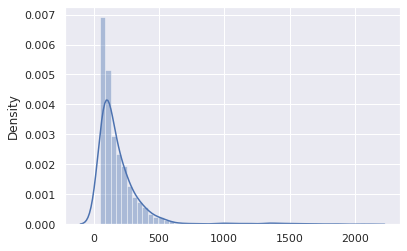

In [172]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [173]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1509,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks,...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,185,<NA>,None,2011-06-22,<NA>,None,You’re correct. We haven’t seen the GDP number...,[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,303,<NA>,None,2011-06-22,<NA>,None,"Well, currently as the statement suggests, we ...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,197,<NA>,None,2011-06-22,<NA>,None,"Thanks, Steve. First, I should start by saying...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,158,<NA>,None,2011-06-22,<NA>,None,"Well, the dollar—the dollar fluctuates. One fa...",[CHAIRMAN BERNANKE. Good afternoon. Welcome.In...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,185,<NA>,None,2020-12-16,<NA>,None,"Thanks. So I'm very reluctant, as you will ima...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1013,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,360,<NA>,None,2020-12-16,<NA>,None,"Sure. So, we have had very little demand below...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1014,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,180,<NA>,None,2020-12-16,<NA>,None,"So when I say we're not out of ammo, I'm looki...",[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1015,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,60,<NA>,None,2020-12-16,<NA>,None,Yes. There's a bunch of programs. I would say ...,[PRELIMINARYTranscript of Chair Powell’s Press...,PRELIMINARY\r\rTranscript of Chair Powell’s Pr...


In [174]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1017, 13)



After (47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7047,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks,...",[Good afternoon. Welcome.In my opening remarks...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
21,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,5635,<NA>,None,2011-08-01,<NA>,None,Good afternoon and welcome.In my opening remar...,[Good afternoon and welcome.In my opening rema...,CHAIRMAN BERNANKE. Good afternoon and welcome....
40,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5519,<NA>,None,2011-11-28,<NA>,None,"Good afternoon, everybody. Welcome.In my openi...","[Good afternoon, everybody. Welcome.In my open...","CHAIRMAN BERNANKE. Good afternoon, everybody. ..."
62,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7488,<NA>,None,2012-03-13,<NA>,None,Good afternoon and welcome.In my opening remar...,[Good afternoon and welcome.In my opening rema...,CHAIRMAN BERNANKE. Good afternoon and welcome....
81,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5453,<NA>,None,2012-06-20,<NA>,None,"Good afternoon. Before we get to questions, I’...","[Good afternoon. Before we get to questions, I...",CHAIRMAN BERNANKE. Good afternoon. Before we g...


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


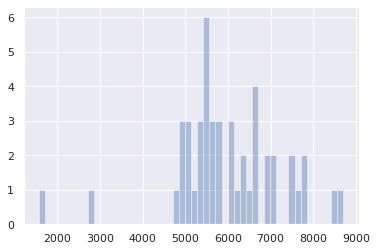

In [175]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [176]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [177]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(1880, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
1875,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,theprogram in a way it's the least thing we co...,"[Good afternoon.At the Federal Reserve, we are...",PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1876,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,set of ones that we ve done And again wehope t...,"[Good afternoon.At the Federal Reserve, we are...",PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1877,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,can do But remember we vealways said this will...,"[Good afternoon.At the Federal Reserve, we are...",PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1878,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,central bank is really funding fiscal activiti...,"[Good afternoon.At the Federal Reserve, we are...",PRELIMINARY\r\rTranscript of Chair Powell’s Pr...
1879,presconf_script,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,71,<NA>,None,2020-12-16,<NA>,None,obligation You change the you change the youkn...,"[Good afternoon.At the Federal Reserve, we are...",PRELIMINARY\r\rTranscript of Chair Powell’s Pr...


### Filter out by keywords

In [178]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3219,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks,...",[Good afternoon. Welcome.In my opening remarks...,CHAIRMAN BERNANKE. Good afternoon. Welcome.\rI...
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2177,<NA>,None,2011-08-01,<NA>,None,Good afternoon and welcome.In my opening remar...,[Good afternoon and welcome.In my opening rema...,CHAIRMAN BERNANKE. Good afternoon and welcome....
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2278,<NA>,None,2011-11-28,<NA>,None,"Good afternoon, everybody. Welcome.In my openi...","[Good afternoon, everybody. Welcome.In my open...","CHAIRMAN BERNANKE. Good afternoon, everybody. ..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,4426,<NA>,None,2012-03-13,<NA>,None,Good afternoon and welcome.In my opening remar...,[Good afternoon and welcome.In my opening rema...,CHAIRMAN BERNANKE. Good afternoon and welcome....
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2050,<NA>,None,2012-06-20,<NA>,None,"Good afternoon. Before we get to questions, I’...","[Good afternoon. Before we get to questions, I...",CHAIRMAN BERNANKE. Good afternoon. Before we g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,presconf_script,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,2528,<NA>,None,2020-06-10,<NA>,None,Good afternoon. Thanks for joining us today. I...,[Good afternoon. Thanks for joining us today. ...,CHAIR POWELL. Good afternoon. Thanks for joini...
43,presconf_script,2020-06-10,FOMC Press Conference Transcript,Jerome Powell,1908,<NA>,None,2020-07-29,<NA>,None,"Good afternoon, everyone, and thanks for joini...","[Good afternoon, everyone, and thanks for join...","CHAIR POWELL. Good afternoon, everyone, and th..."
44,presconf_script,2020-07-29,FOMC Press Conference Transcript,Jerome Powell,2957,<NA>,None,2020-08-27,<NA>,None,Good afternoon. The pandemic continues to caus...,[Good afternoon. The pandemic continues to cau...,CHAIR POWELL. Good afternoon. The pandemic con...
45,presconf_script,2020-09-16,FOMC Press Conference Transcript,Jerome Powell,2730,<NA>,None,2020-11-05,<NA>,None,"Good afternoon. At the Federal Reserve, we are...","[Good afternoon. At the Federal Reserve, we ar...",CHAIR POWELL. Good afternoon. At the Federal R...


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


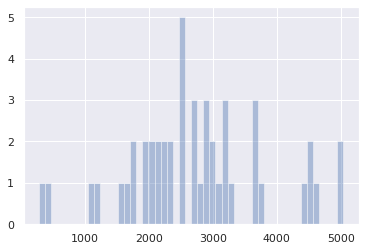

In [179]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [180]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [181]:
# Sample
print(meeting_script_df['contents'][2])

--and we need a nomination.

[SECTION]

of the FOMC!

[SECTION]

CHAIRMAN VOLCKER.

[SECTION]

MR. PARTEE.

[SECTION]



[SECTION]

that way!

[SECTION]



[SECTION]

Chairman.

[SECTION]

Vice Chairman of the FOMC.

[SECTION]

date. Is there a second?

[SECTION]



[SECTION]

the nominees.

[SECTION]

That's the list, Mr. Chairman.

[SECTION]

plenitude of Davises--pardon me?

[SECTION]



[SECTION]

motion to that effect?

[SECTION]



[SECTION]

[reappointment them]?

[SECTION]



[SECTION]

have a motion?

[SECTION]



[SECTION]

CHAIRMAN VOLCKER.

[SECTION]



[SECTION]

since the last meeting, Mr. Pardee.

[SECTION]



[SECTION]

price of gold. Would that include any major commercial banks?

[SECTION]

past from the U.S. Treasury.

[SECTION]



[SECTION]

they can withstand such losses.

[SECTION]

dollar to go up in the face of that?

[SECTION]

bearish.

[SECTION]

of that?

[SECTION]

amounts.

[SECTION]

absence of intervention.

[SECTION]

[the dollar] has been pretty steady

In [182]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  282
Shape of the dataframe:  (282, 13)


In [183]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.secur...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting ...,[CHAIRMAN VOLCKER. I will call the non-meeting...,CHAIRMAN VOLCKER. I will call the non-meeting ...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,CHAIRMAN VOLCKER. The meeting can come to orde...,[CHAIRMAN VOLCKER. The meeting can come to ord...,CHAIRMAN VOLCKER. The meeting can come to orde...
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies ...","[CHAIRMAN VOLCKER.Can we come to order, ladies...","CHAIRMAN VOLCKER.\rCan we come to order, ladie..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and g...","[CHAIRMAN VOLCKER. Let us proceed, ladies and ...","CHAIRMAN VOLCKER. Let us proceed, ladies and g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,CHAIR YELLEN. I’d like to begin by welcoming t...,[CHAIR YELLEN. I’d like to begin by welcoming ...,CHAIR YELLEN. I’d like to begin by welcoming t...
278,meeting_script,2014-07-30,FOMC Meeting Transcript,Janet Yellen,90853,<NA>,None,2014-09-17,<NA>,None,"CHAIR YELLEN. Good morning, everybody. I would...","[CHAIR YELLEN. Good morning, everybody. I woul...","CHAIR YELLEN. Good morning, everybody. I would..."
279,meeting_script,2014-09-17,FOMC Meeting Transcript,Janet Yellen,62779,<NA>,None,2014-10-29,<NA>,None,"CHAIR YELLEN. Good morning, everybody.Our firs...","[CHAIR YELLEN. Good morning, everybody.Our fir...","CHAIR YELLEN. Good morning, everybody.\rOur fi..."
280,meeting_script,2014-10-29,FOMC Meeting Transcript,Janet Yellen,74510,<NA>,None,2014-12-17,<NA>,None,CHAIR YELLEN. I’d like to call this meeting to...,[CHAIR YELLEN. I’d like to call this meeting t...,CHAIR YELLEN. I’d like to call this meeting to...


In [184]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.secur...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting ...,[CHAIRMAN VOLCKER. I will call the non-meeting...,CHAIRMAN VOLCKER. I will call the non-meeting ...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,CHAIRMAN VOLCKER. The meeting can come to orde...,[CHAIRMAN VOLCKER. The meeting can come to ord...,CHAIRMAN VOLCKER. The meeting can come to orde...
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies ...","[CHAIRMAN VOLCKER.Can we come to order, ladies...","CHAIRMAN VOLCKER.\rCan we come to order, ladie..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and g...","[CHAIRMAN VOLCKER. Let us proceed, ladies and ...","CHAIRMAN VOLCKER. Let us proceed, ladies and g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,CHAIR YELLEN. I’d like to begin by welcoming t...,[CHAIR YELLEN. I’d like to begin by welcoming ...,CHAIR YELLEN. I’d like to begin by welcoming t...
278,meeting_script,2014-07-30,FOMC Meeting Transcript,Janet Yellen,90853,<NA>,None,2014-09-17,<NA>,None,"CHAIR YELLEN. Good morning, everybody. I would...","[CHAIR YELLEN. Good morning, everybody. I woul...","CHAIR YELLEN. Good morning, everybody. I would..."
279,meeting_script,2014-09-17,FOMC Meeting Transcript,Janet Yellen,62779,<NA>,None,2014-10-29,<NA>,None,"CHAIR YELLEN. Good morning, everybody.Our firs...","[CHAIR YELLEN. Good morning, everybody.Our fir...","CHAIR YELLEN. Good morning, everybody.\rOur fi..."
280,meeting_script,2014-10-29,FOMC Meeting Transcript,Janet Yellen,74510,<NA>,None,2014-12-17,<NA>,None,CHAIR YELLEN. I’d like to call this meeting to...,[CHAIR YELLEN. I’d like to call this meeting t...,CHAIR YELLEN. I’d like to call this meeting to...


(282, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


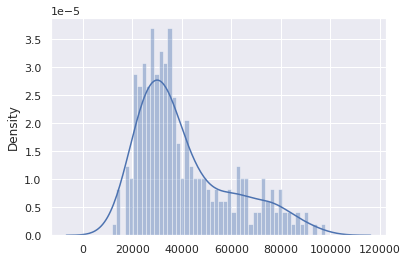

In [185]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [186]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

Streaming output truncated to the last 5000 lines.

not matched:  MR. HOENIG.Thank you.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.The inflation blip but not the nominal GDPblip?
1994-07-06 00:00:00

not matched:  MR. KOHN.I call on Mr. Kohn.[Statement--See Appendix.]
1994-07-06 00:00:00

not matched:  MR. KOHN.I think the models embody a vertical long-runPhillips curve; it takes a while for it to come out here.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Into the next millennium!If you had not noticed that the inflation
1994-07-06 00:00:00

not matched:  MR. KOHN.But never backwards?No.Only the coefficient is unchanged even
1994-07-06 00:00:00

not matched:  MR. KOHN.stretched out--In this time period, that's right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.No, go ahead, please finish.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.And when will we ever pay the price?
1994-07-06 00:00:00

not matched:  MR. LINDSEY.But t

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMA,4,<NA>,None,1980-02-05,<NA>,None,VOLCKER.securities] since when?,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,25,<NA>,None,1980-02-05,<NA>,None,"Steve, if you want to add something thatbears ...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1205,<NA>,None,1980-02-05,<NA>,None,"Mr. Chairman, we have some tables we could pas...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,31,<NA>,None,1980-02-05,<NA>,None,"I'm sure that's crystal clear!So, Ithink it's ...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. PARTEE,107,<NA>,None,1980-02-05,<NA>,None,"Well, just a comment. I think I understood the...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities]...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88214,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,79,<NA>,None,2015-01-28,<NA>,None,Thank you. Okay. I think the main open issue i...,"[CHAIR YELLEN. Good afternoon, everyone. I thi...","CHAIR YELLEN. Good afternoon, everyone. I thin..."
88215,meeting_script,2014-12-17,FOMC Meeting Transcript,MR. LUECKE,47,<NA>,None,2015-01-28,<NA>,None,"This vote, as Chair Yellen indicated, will be ...","[CHAIR YELLEN. Good afternoon, everyone. I thi...","CHAIR YELLEN. Good afternoon, everyone. I thin..."
88216,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,71,<NA>,None,2015-01-28,<NA>,None,Okay. Thank you very much. And let me confirm ...,"[CHAIR YELLEN. Good afternoon, everyone. I thi...","CHAIR YELLEN. Good afternoon, everyone. I thin..."
88217,meeting_script,2014-12-17,FOMC Meeting Transcript,MR. FISCHER,6,<NA>,None,2015-01-28,<NA>,None,"Thank you, Madam Chair. December 16–17, 201417...","[CHAIR YELLEN. Good afternoon, everyone. I thi...","CHAIR YELLEN. Good afternoon, everyone. I thin..."


Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [187]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88219, 13)
After:  (47498, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


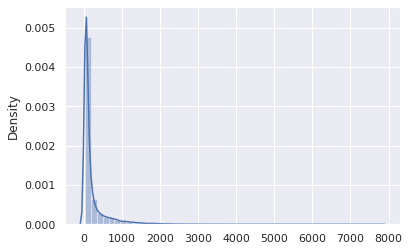

In [188]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [189]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df

,index,text,text_sections,word_count
0,1,"Steve, if you want to add something thatbears ...","[S, t, e, v, e, ,, , i, f, , y, o, u, , w, ...",25
1,2,"Mr. Chairman, we have some tables we could pas...","[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, ...",1205
2,3,"I'm sure that's crystal clear!So, Ithink it's ...","[I, ', m, , s, u, r, e, , t, h, a, t, ', s, ...",31
3,4,"Well, just a comment. I think I understood the...","[W, e, l, l, ,, , j, u, s, t, , a, , c, o, ...",107
4,6,"Well, one of the things that is disturbing me-...","[W, e, l, l, ,, , o, n, e, , o, f, , t, h, ...",131
...,...,...,...,...
47493,88209,"Thank you. Since we last met, we have seen two...","[T, h, a, n, k, , y, o, u, ., , S, i, n, c, ...",480
47494,88213,No worries. It happened one time under Chairma...,"[N, o, , w, o, r, r, i, e, s, ., , I, t, , ...",1412
47495,88214,Thank you. Okay. I think the main open issue i...,"[T, h, a, n, k, , y, o, u, ., , O, k, a, y, ...",79
47496,88215,"This vote, as Chair Yellen indicated, will be ...","[T, h, i, s, , v, o, t, e, ,, , a, s, , C, ...",47


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


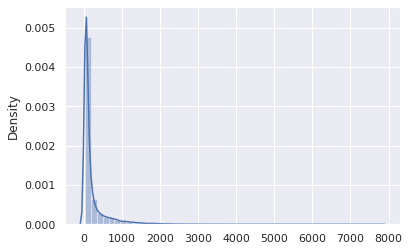

In [190]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [191]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df

KeyError: ignored

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df

In [ ]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [ ]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

In [ ]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

In [ ]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

### Split contents to max 200 words

In [ ]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df

In [ ]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [ ]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

In [ ]:
# Check the returned dataframe
proc_testimony_df

In [ ]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

### Split contents to max 200 words

In [ ]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df

In [ ]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [ ]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [ ]:
def save_data(df, file_name, dir_name=preprocessed_dir):
  if not os.path.exists(dir_name):
    os.mkdir(dir_name)

  # Save results to a picke file
  file = open(dir_name + file_name + '.pickle', 'wb')
  pickle.dump(df, file)
  file.close()
  print("Data Saved to a pickle file in {} !".format(dir_name))

  # Save results to a csv file
  df.to_csv(dir_name + file_name + '.csv', index=True)
  print("Data Saved to a csv file in {} !".format(dir_name))

In [ ]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')